In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PEAD = pd.read_csv('PEAD.csv')
market = pd.read_csv('market.csv')
PEAD = pd.merge(PEAD,market, on = 'DATE')
PEAD['DATE'] = pd.to_datetime(PEAD.DATE,format = "%Y%m%d")

In [6]:
event_idx = PEAD[PEAD['ann'] == 1].index
stdized_excess_returns = []
for idx in event_idx:
    permno = PEAD['PERMNO'][idx]
    event_date = PEAD['DATE'][idx]
    excess = PEAD['RET'][idx] - PEAD['ret_m'][idx]

    data = PEAD[PEAD['PERMNO'] == permno]
    data = data.reset_index(drop = True)
    new_idx = data[data['DATE'] == event_date].index[0]

    window_start = event_date - pd.to_timedelta('60 days')
    window_start_idx = data[data['DATE']>=window_start].index[0]
    window = data[window_start_idx:new_idx+1]

    sigma = window['RET'].std()
    stdized_excess = excess / sigma
    stdized_excess_returns.append(stdized_excess)

stdized_excess_returns = np.array(stdized_excess_returns)

In [7]:
k = 3

most_positive_idx = event_idx[np.where(stdized_excess_returns>=k)[0]]
most_negative_idx = event_idx[np.where(stdized_excess_returns<=-k)[0]]

most_positive_avrg_30 = []
most_negative_avrg_30 = []

most_positive_raw = []
most_negative_raw = []

for idx in most_positive_idx:
    if PEAD['ann'][idx] != 1: raise RuntimeError('FUCK YOU')
    permno = PEAD['PERMNO'][idx]
    event_date = PEAD['DATE'][idx]
    data = PEAD[PEAD['PERMNO'] == permno]
    data = data.reset_index(drop = True)
    new_idx = data[data['DATE'] == event_date].index[0]

    if data['ann'][new_idx] != 1: raise RuntimeError('MOTHERFUCKER')
    window_end = event_date + pd.to_timedelta('30 days')
    window_end_idx = data[data['DATE'] <= window_end].index[-1]
    window = data[new_idx:window_end_idx+1]
    avrg_return = window['RET'].mean()
    most_positive_raw.append(window['RET'])
    most_positive_avrg_30.append(avrg_return)

for idx in most_negative_idx:
    if PEAD['ann'][idx] != 1: raise RuntimeError('FUCK YOU')
    permno = PEAD['PERMNO'][idx]
    event_date = PEAD['DATE'][idx]
    data = PEAD[PEAD['PERMNO'] == permno]
    data = data.reset_index(drop = True)
    new_idx = data[data['DATE'] == event_date].index[0]

    if data['ann'][new_idx] != 1: raise RuntimeError('MOTHERFUCKER')
    window_end = event_date + pd.to_timedelta('30 days')
    window_end_idx = data[data['DATE'] <= window_end].index[-1]
    window = data[new_idx:window_end_idx+1]
    avrg_return = window['RET'].mean()
    most_negative_raw.append(window['RET'])
    most_negative_avrg_30.append(avrg_return)


In [13]:
most_negative_avrg_30 = np.array(most_negative_avrg_30)
most_positive_avrg_30 = np.array(most_positive_avrg_30)

all_returns = np.append(most_negative_avrg_30, most_positive_avrg_30)

all_mean = all_returns.mean()
pos_mean = most_positive_avrg_30.mean()
neg_mean = most_negative_avrg_30.mean()
pos_l = len(most_positive_avrg_30)
neg_l = len(most_negative_avrg_30)

SST = np.square(all_returns - all_mean).sum()
SSG = (pos_mean - all_mean)**2 * pos_l + (neg_mean - all_mean)**2 * neg_l
SSE = SST - SSG

dfT = pos_l + neg_l
dfG = 2 - 1 
dfE = dfT - dfG

MSG = SSG/dfG
MSE = SSE/dfE

f = MSG/MSE

from scipy import stats

1 - stats.f.cdf(f,pos_l+neg_l, 1)

0.014328514908458212

In [64]:
all_sum = 0
num_obs = 0
for series in most_positive_raw:
    all_sum += series.sum()
    num_obs += len(series)
all_mean = all_sum / num_obs
SST = 0
SSG = 0
i= 0
for series in most_positive_raw:
    series = series.fillna(0)
    SST += np.square(np.array(series - all_mean)).sum()
    SSG += (series.mean() - all_mean)**2 * len(series)

SSE = SST-SSG
dfT = num_obs
dfG = len(most_negative_raw) - 1
dfE = dfT - dfG

MSG = SSG/dfG
MSE = SSE/dfE

f = MSG/MSE

from scipy import stats

1 - stats.f.cdf(f,pos_l+neg_l, 1)

0.8208258627894587

In [65]:
all_sum = 0
num_obs = 0
for series in most_negative_raw + most_positive_raw:
    all_sum += series.sum()
    num_obs += len(series)
all_mean = all_sum / num_obs
SST = 0
SSG = 0
i= 0
for series in most_negative_raw + most_positive_raw:
    series = series.fillna(0)
    SST += np.square(np.array(series - all_mean)).sum()
    SSG += (series.mean() - all_mean)**2 * len(series)

SSE = SST-SSG
dfT = num_obs
dfG = len(most_negative_raw) + len(most_positive_raw) - 1
dfE = dfT - dfG

MSG = SSG/dfG
MSE = SSE/dfE

f = MSG/MSE

from scipy import stats
1 - stats.f.cdf(f,pos_l+neg_l, 1)

0.6924550889047858

(b)

In [66]:
def backtest(n):
    performance = dict()
    #initialize dictionary
    for date in pd.to_datetime(PEAD['DATE'].unique()):
        performance[date] = []


    for idx in most_positive_idx:
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement

        data = PEAD[PEAD['PERMNO'] == permno]
        data = data.reset_index(drop = True)
        new_idx = data[data['DATE'] == event_date].index[0] 

        pos_close_date = event_date + pd.to_timedelta(str(n) + ' days')
        pos_close_idx = data[data['DATE'] <= pos_close_date].index[-1]

        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to fund
            date_diff = pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day")
            total_return = (1 + data['RET'][idx]) * np.exp(-date_diff/360 * 0.03)#penalize for funding
            performance[date].append(total_return)

    for idx in most_negative_idx:
        if PEAD['ann'][idx] != 1: raise RuntimeError('FUCK YOU')        
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement

        data = PEAD[PEAD['PERMNO'] == permno]
        data = data.reset_index(drop = True)
        new_idx = data[data['DATE'] == event_date].index[0] 
        if data['ann'][new_idx] != 1: raise RuntimeError('MOTHERFUCKER')

        pos_close_date = event_date + pd.to_timedelta(str(n) + ' days')
        pos_close_idx = data[data['DATE'] <= pos_close_date].index[-1]

        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to earn interest
            date_diff = pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day")
            total_return = (1 - data['RET'][idx]) * np.exp(date_diff/360 * 0.01)
            performance[date].append(total_return)


    returns = pd.DataFrame(pd.to_datetime(PEAD['DATE'].unique()),columns = ['Date'])
    returns = returns.set_index('Date',drop = True)
    returns['Ret'] = 1

    for date in performance:
        return_arr = np.array(performance[date])
        if len(return_arr) > 0:
            returns.loc[date,'Ret'] = return_arr.mean()

    return returns['Ret']

In [ ]:
def backtest_by_trading_day(n):
    performance = dict()
    #initialize dictionary
    for date in pd.to_datetime(PEAD['DATE'].unique()):
        performance[date] = []


    for idx in most_positive_idx:
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement

        data = PEAD[PEAD['PERMNO'] == permno]
        data = data.reset_index(drop = True)
        new_idx = data[data['DATE'] == event_date].index[0]    
        pos_close_idx = new_idx + n

        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to fund
            date_diff = pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day")
            total_return = (1 + data['RET'][idx]) * np.exp(-date_diff/360 * 0.03)#penalize for funding
            performance[date].append(total_return)

    for idx in most_negative_idx:    
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement

        data = PEAD[PEAD['PERMNO'] == permno]
        data = data.reset_index(drop = True)
        new_idx = data[data['DATE'] == event_date].index[0]
        pos_close_idx = new_idx + n

        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to earn interest
            date_diff = pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day")
            total_return = (1 - data['RET'][idx]) * np.exp(date_diff/360 * 0.01)
            performance[date].append(total_return)


    returns = pd.DataFrame(pd.to_datetime(PEAD['DATE'].unique()),columns = ['Date'])
    returns = returns.set_index('Date',drop = True)
    returns['Ret'] = 1

    for date in performance:
        return_arr = np.array(performance[date])
        if len(return_arr) > 0:
            returns.loc[date,'Ret'] = return_arr.mean()

    return returns['Ret']

In [99]:
def AR(n):
    performance = dict()
    for i in range(1,n+1):
        performance[i] = []

    for idx in most_positive_idx:
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement

        data = PEAD[PEAD['PERMNO'] == permno]  
        data = data.reset_index(drop = True)
        new_idx = data[data['DATE'] == event_date].index[0] 

        pos_close_date = event_date + pd.to_timedelta(str(n) + ' days')
        pos_close_idx = data[data['DATE'] <= pos_close_date].index[-1]


        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to fund
            date_diff = int(pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day"))  
            total_return = (1 + data['RET'][idx]) * np.exp(-date_diff/360 * 0.03)#penalize for funding
            date_event_diff = int(pd.to_timedelta(date - event_date)/ pd.to_timedelta("1 day")) 
            performance[date_event_diff].append(total_return)


    for idx in most_negative_idx:       
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement

        data = PEAD[PEAD['PERMNO'] == permno]
        data = data.reset_index(drop = True)
        new_idx = data[data['DATE'] == event_date].index[0] 

        pos_close_date = event_date + pd.to_timedelta(str(n) + ' days')
        pos_close_idx = data[data['DATE'] <= pos_close_date].index[-1]

        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to earn interest
            date_diff = int(pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day"))
            total_return = (1 - data['RET'][idx]) * np.exp(date_diff/360 * 0.01)
            date_event_diff = int(pd.to_timedelta(date - event_date)/ pd.to_timedelta("1 day")) 
            performance[date_event_diff].append(total_return)

    returns = dict()

    for date in performance:
        return_arr = np.array(performance[date])
        returns[date] = return_arr.mean()
    return returns


In [104]:
def AR_by_trading_day(n):
    performance = dict()
    for i in range(1,n+1):
        performance[i] = []

    for idx in most_positive_idx:
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement

        data = PEAD[PEAD['PERMNO'] == permno]  
        data = data.reset_index(drop = True)
        new_idx = data[data['DATE'] == event_date].index[0] 
        pos_close_idx = new_idx + n


        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to fund
            date_diff = int(pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day"))  
            total_return = (1 + data['RET'][idx]) * np.exp(-date_diff/360 * 0.03)#penalize for funding
            performance[idx - new_idx].append(total_return)


    for idx in most_negative_idx:       
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement

        data = PEAD[PEAD['PERMNO'] == permno]
        data = data.reset_index(drop = True)
        new_idx = data[data['DATE'] == event_date].index[0] 
        pos_close_idx = new_idx + n

        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to earn interest
            date_diff = int(pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day"))
            total_return = (1 - data['RET'][idx]) * np.exp(date_diff/360 * 0.01)
            performance[idx - new_idx].append(total_return)

    returns = dict()

    for date in performance:
        return_arr = np.array(performance[date])
        returns[date] = return_arr.mean()
    return returns

In [101]:
AR_5 = AR(5)
AR_10 = AR(10)
AR_20 = AR(20)
AR_30 = AR(30)


In [102]:
AR_5_by_trading_day = AR_by_trading_day(5)
AR_10_by_trading_day = AR_by_trading_day(10)
AR_20_by_trading_day = AR_by_trading_day(20)
AR_30_by_trading_day = AR_by_trading_day(30)


KeyError: 6

In [67]:
# fund value plot
ret_5 = backtest(5)
ret_10 = backtest(10)
ret_20 = backtest(20)
ret_30 = backtest(30)

value_5 = ret_5.cumprod()
value_10 = ret_10.cumprod()
value_20 = ret_20.cumprod()
value_30 = ret_30.cumprod()

In [ ]:
ret_5_by_trading_day = backtest_by_trading_day(5)
ret_10_by_trading_day = backtest_by_trading_day(10)
ret_20_by_trading_day = backtest_by_trading_day(20)
ret_30_by_trading_day = backtest_by_trading_day(30)

value_5_by_trading_day = ret_5.cumprod()
value_10_by_trading_day = ret_10.cumprod()
value_20_by_trading_day = ret_20.cumprod()
value_30_by_trading_day = ret_30.cumprod()

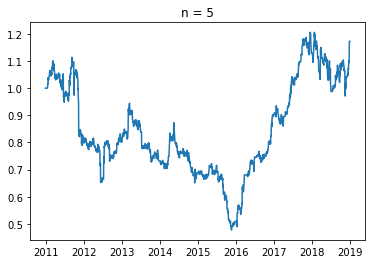

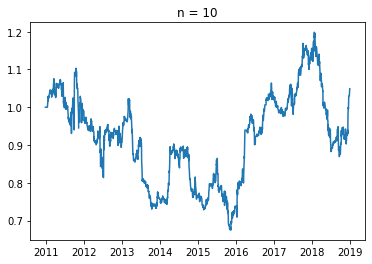

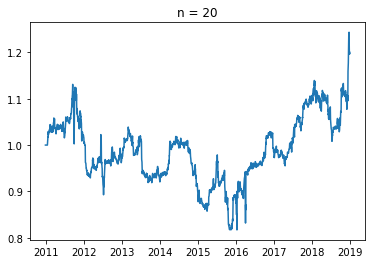

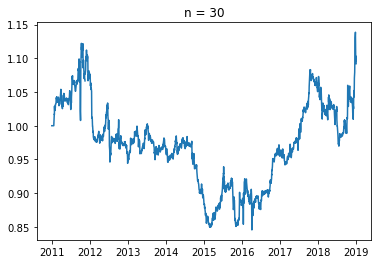

In [73]:
plt.plot(value_5)
plt.title("n = 5")
plt.show()


plt.plot(value_10)
plt.title("n = 10")
plt.show()


plt.plot(value_20)
plt.title("n = 20")
plt.show()


plt.plot(value_30)
plt.title("n = 30")
plt.show()


In [54]:
FF_factors = pd.read_csv("F-F_Research_Data_Factors_daily.csv", skiprows=4)[20000:-1]
FF_factors.columns = ["Date", 'Mkt-RF', 'SMB', 'HML', 'RF']
FF_factors['Date'] = pd.to_datetime(FF_factors['Date'],format = '%Y%m%d')

In [55]:
FF_5 = pd.merge(FF_factors,ret_5 - 1,on = 'Date')
FF_10 = pd.merge(FF_factors,ret_10 - 1,on = 'Date')
FF_20 = pd.merge(FF_factors,ret_20 - 1,on = 'Date')
FF_30 = pd.merge(FF_factors,ret_30 - 1,on = 'Date')

In [72]:
import statsmodels.api as sm
for FF in [FF_5,FF_10,FF_20,FF_30]:
    FF = FF.fillna(0)
    Y = FF['Ret'] - FF['RF']
    X = sm.add_constant(FF[['Mkt-RF','SMB','HML']])/100
    print(sm.OLS(Y,X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.947
Date:                Sat, 10 Apr 2021   Prob (F-statistic):              0.120
Time:                        18:22:15   Log-Likelihood:                 6005.2
No. Observations:                2013   AIC:                        -1.200e+04
Df Residuals:                    2009   BIC:                        -1.198e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1290      0.027     -4.713      0.0

In [69]:
#FF_30[FF_30.isna().any(axis=1)]

,Date,Mkt-RF,SMB,HML,RF,Ret
222,2011-11-16,-1.64,-0.15,-0.18,0.0,NaN
481,2012-11-29,0.54,0.68,-0.01,0.0,NaN
